In [1]:
import json
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from kt_base_model import KT
from kt_ec_e2e_model import KT as KT_E2E
from kt_ec_e2e_model import ECData

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
n_question = 8
n_pid = 1500
seq_len = 30
n_blocks = 1
mid_size = 64
d_model = 128
dropout = 0.05
epoch_num = 150

In [3]:
kt_net = KT(n_question=n_question, n_pid=n_pid, n_blocks=n_blocks, d_model=d_model, dropout=dropout)
# kt_net.eval()

In [4]:
with open('../test11b/problem_data_a.json', 'r', encoding='utf8')as fp:
    data = json.load(fp)
with open('../test11b/glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()

trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

name_dict = {'array': 0, 'hash-table': 1, 'math': 2, 'string': 3,
             'dynamic-programming': 4, 'greedy': 5, 'sorting': 6, 'depth-first-search': 7}

glove = ECData(data=data, name_dict=name_dict, trained_dict=trained_dict, 
               train_path='./ec_train_data.json', test_path='./ec_test_data.json')
glove.get_words()
glove.get_id()

In [5]:
kt_e2e = KT_E2E(ec_data=glove, n_question=n_question, n_pid=n_pid, 
                n_blocks=n_blocks, mid_size=mid_size, dropout=dropout)
state = torch.load('./results/ec+kt+e2e_model.pth')
kt_e2e.load_state_dict(state['kt_net'])
# kt_e2e.eval()

d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [6]:
pth_lst = ['./results/kt_base_model.pth', './results/kt_pre_model.pth',
           './results/ec+kt+mtl_model.pth', './results/ec+kt+e2e_model.pth']
ttl_lst = ['(a) KT base', '(b) KT+EC-pre', '(c) KT+EC+mtl', '(d) KT+EC+e2e']
lbl_lst = ['array', 'hash', 'math', 'string', 'DP', 'greedy', 'sorting', 'DFS']

pro_t = [500,271,271,81,256,256,256,256,81,70,346,1195,263,263,263,1497,1497,847,866,380,380,171,171,1425,928,933,933,933,1429,1429]
con_t = [[0,6],[2],[2],[3],[0],[0],[0],[0],[3],[0],[0,1],[2],[2],[2],[2],[3],[3],[2,5],[4],[0,2,3,6],[0,2,3,6],[0,1],[0,1],[0,2,5],[0,1],[3],[3],[3],[1],[1]]
ans_t = [1,1,1,0,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1]

In [7]:
p_lst, q_lst, a_lst = [], [], []
for i in range(len(ans_t)):
    que = [0] * n_question
    ans = [0] * (2 * n_question)
    for q in con_t[i]:
        que[q] = 1
        ans[q + ans_t[i] * n_question] = ans_t[i] * 2 - 1
    q_lst.append(que)
    a_lst.append(ans)
    p_lst.append(pro_t[i])

a_seq, q_seq, p_seq = torch.FloatTensor(a_lst).cuda(), torch.FloatTensor(q_lst).cuda(), torch.LongTensor(p_lst).cuda()
a_seq, q_seq, p_seq = a_seq.unsqueeze(0), q_seq.unsqueeze(0), p_seq.unsqueeze(0)

base, pre, mtl ok


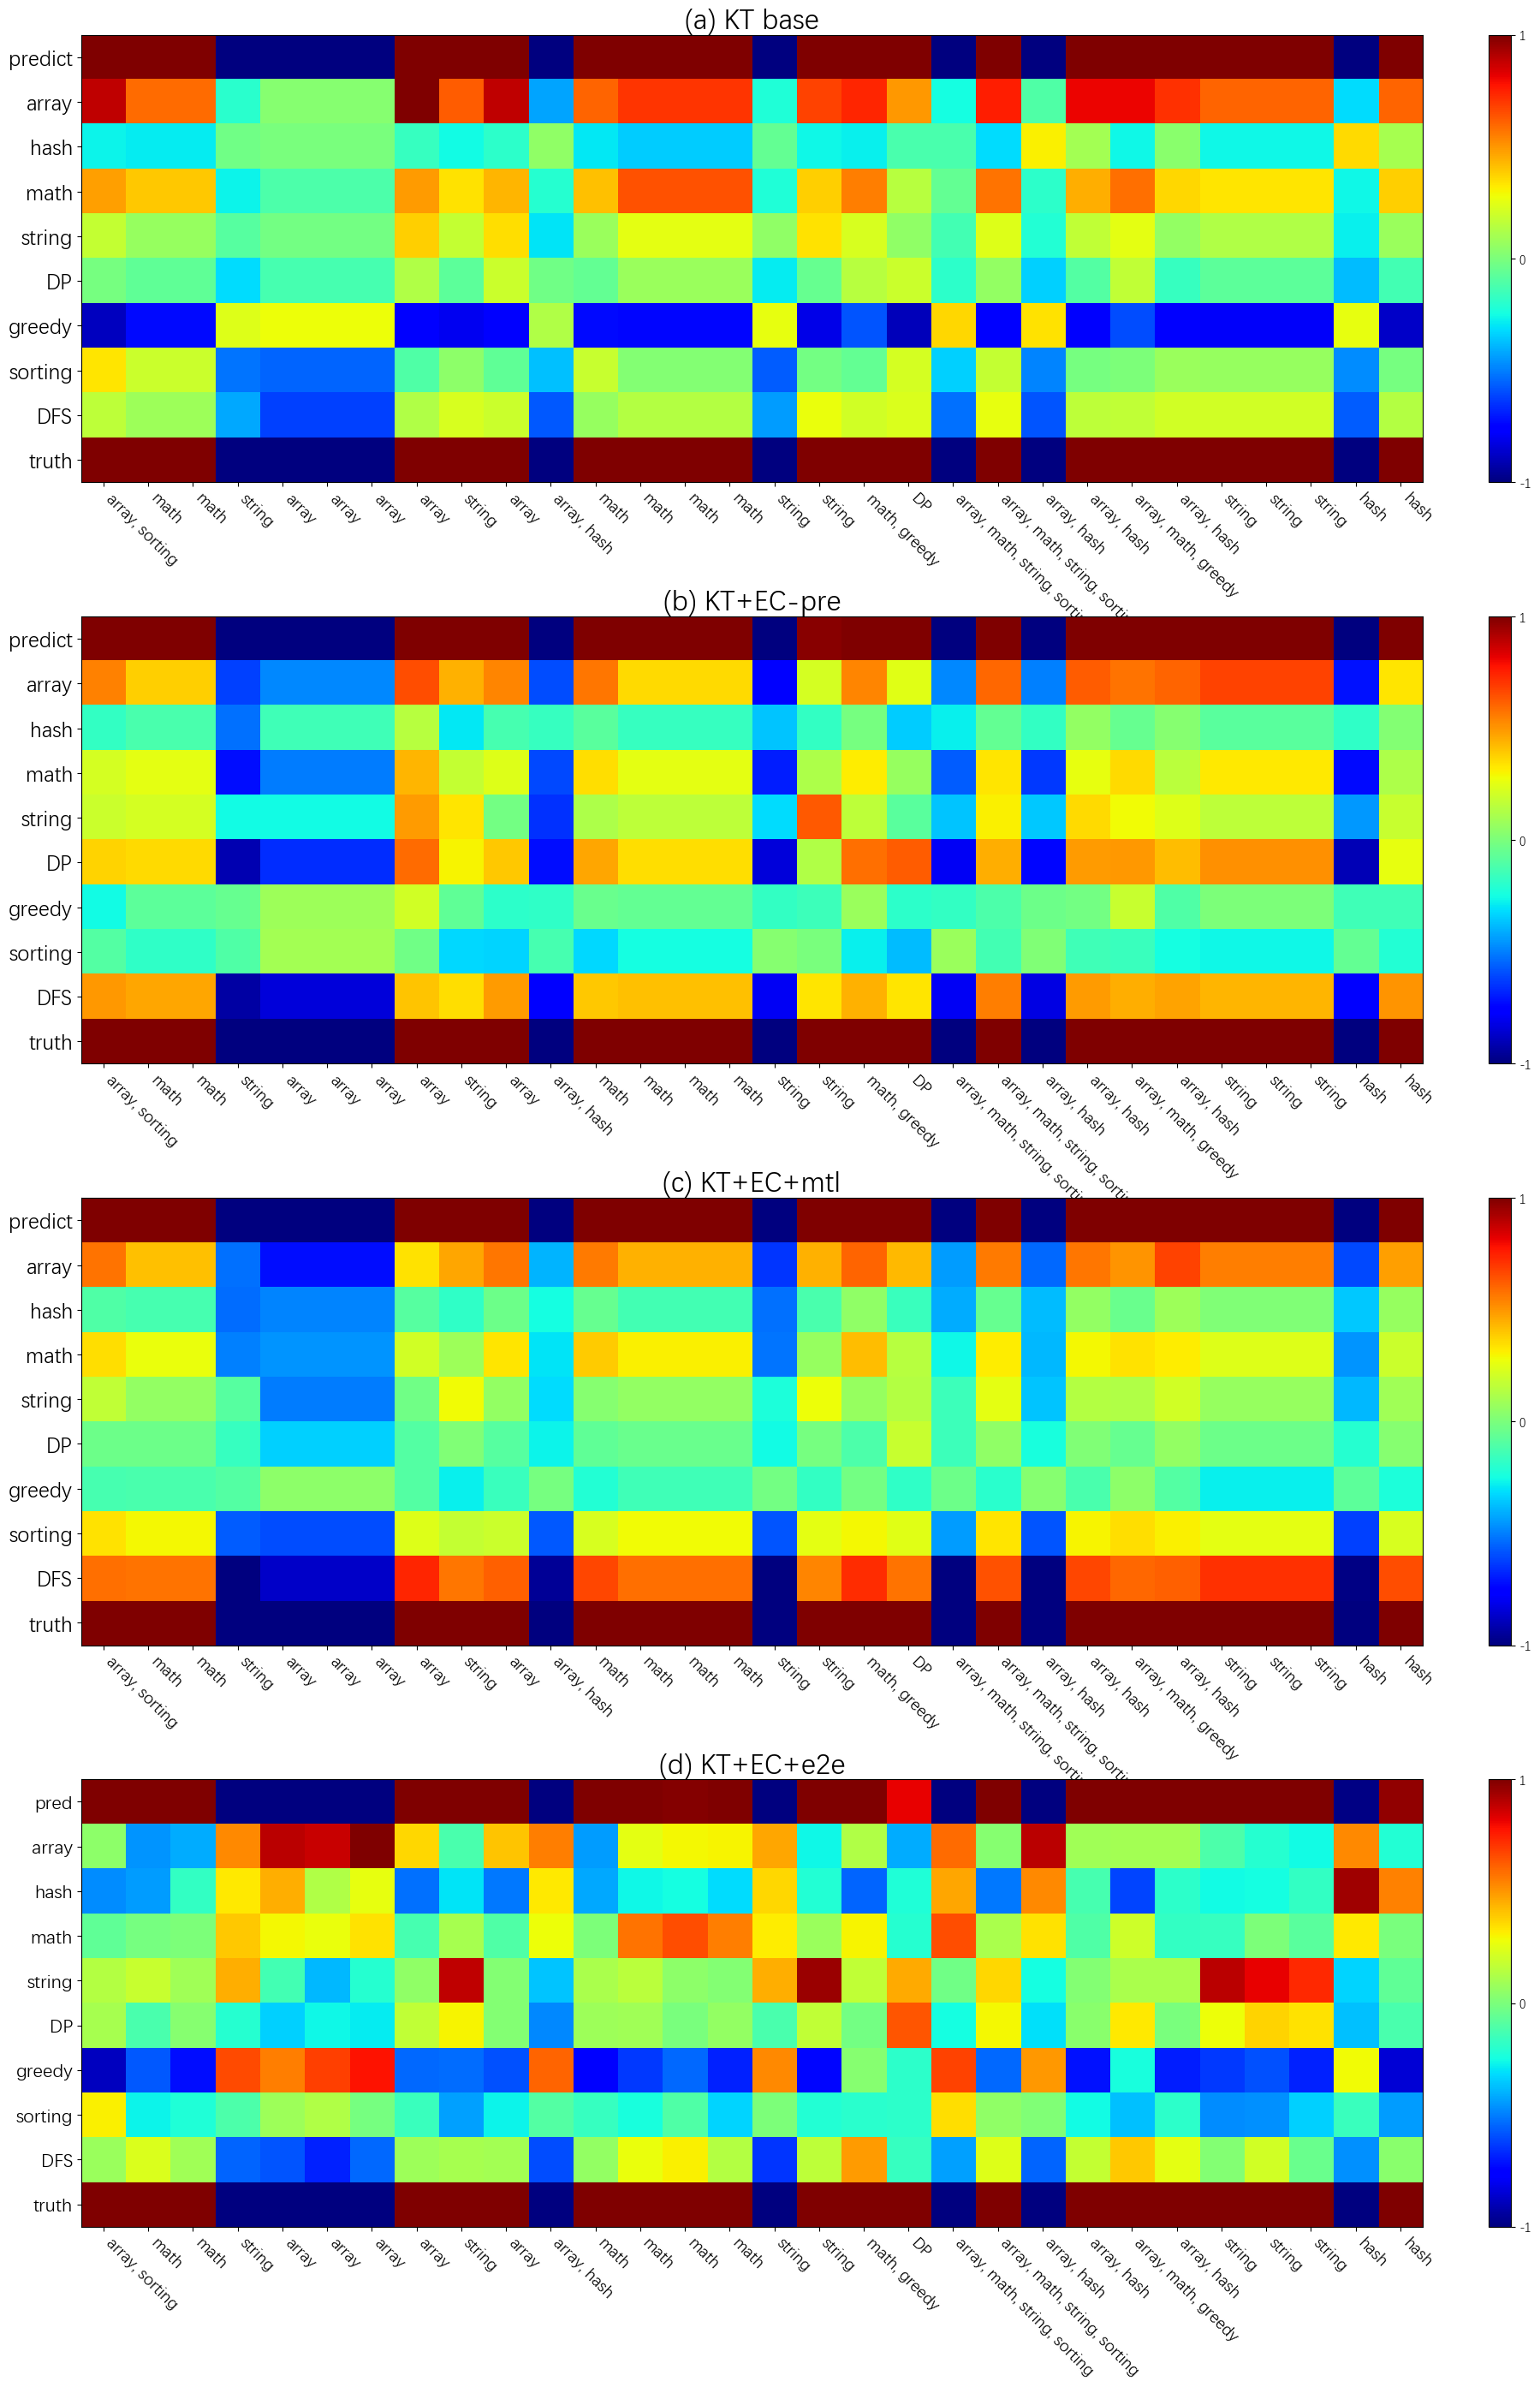

In [8]:
fig = plt.figure(num=1, figsize=(24, 32), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)

for i in range(3):
    state = torch.load(pth_lst[i])
    kt_net.load_state_dict(state['kt_net'])
    kt_net.eval()

    out, dst = kt_net(q_seq, a_seq, p_seq, need=True)
    out, dst = out[0].detach().cpu().numpy(), dst[0].detach().cpu().numpy()
    out, dst = out.transpose(), dst.transpose()

    mat = kt_net.q_embed.weight.detach().cpu().numpy()
    mat = np.linalg.pinv(mat)
    dst = np.matmul(mat, dst)
    dst = (dst - np.mean(dst)) / np.std(dst) / 2.5
    tru = (2 * np.array(ans_t) - 1).reshape((1, -1))
    dst = np.concatenate([out, dst, tru], axis=0)

    axe = fig.add_subplot(4, 1, i + 1)
    axe.set_xticks(range(dst.shape[1]))
    axe.set_xticklabels([', '.join([lbl_lst[c] for c in con]) for con in con_t], rotation=-45, ha='left', fontsize=14)
    axe.set_yticks(range(dst.shape[0]))
    axe.set_yticklabels(['predict'] + lbl_lst + ['truth'], fontsize=18)
    axe.set_title(ttl_lst[i], fontsize=24)
    img = axe.imshow(dst, interpolation='nearest', cmap=mpl.cm.jet, vmin=-1, vmax=1)  #
    plt.colorbar(img, ticks=[-1, 0, 1], fraction=0.046, pad=0.04)

print('base, pre, mtl ok')

out, dst = kt_e2e(a_seq, p_seq, need=True)
out, dst = out[0].detach().cpu().numpy(), dst[0].detach().cpu().numpy()
out, dst = out.transpose(), dst.transpose()

mat = kt_e2e.q_embed.weight.detach().cpu().numpy()
mat = np.linalg.pinv(mat)
dst = np.matmul(mat, dst)
dst = (dst - np.mean(dst)) / np.std(dst) / 2.5
tru = (2 * np.array(ans_t) - 1).reshape((1, -1))
dst = np.concatenate([out, dst, tru], axis=0)

axe = fig.add_subplot(4, 1, 4)
axe.set_xticks(range(dst.shape[1]))
axe.set_xticklabels([', '.join([lbl_lst[c] for c in con]) for con in con_t], rotation=-45, ha='left', fontsize=14)
axe.set_yticks(range(dst.shape[0]))
axe.set_yticklabels(['pred'] + lbl_lst + ['truth'], fontsize=16)
axe.set_title(ttl_lst[3], fontsize=24)
img = axe.imshow(dst, interpolation='nearest', cmap=mpl.cm.jet, vmin=-1, vmax=1) 
plt.colorbar(img, ticks=[-1, 0, 1], fraction=0.046, pad=0.04)

plt.savefig('./results/cmp_kt/cmp_kt_pro.jpg')
plt.show()